🖥  device : cuda:0
Pixel Shape: 1024x1024
✅ IQ tensor : (1, 2, 1024, 1024)
✅ Model loaded.
✅ Output : (1, 2, 1024, 1024)
🖫 Saved prediction → C:\Users\user\workspace\IqPixelGrid_HSB\IQBF_1024x1024\dclPrediction.npy


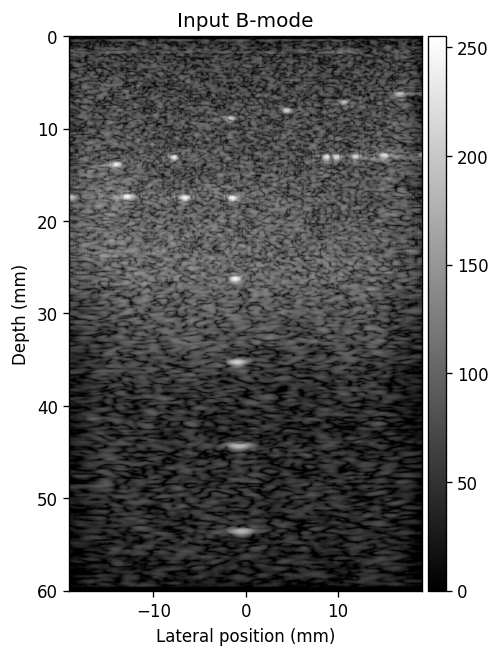

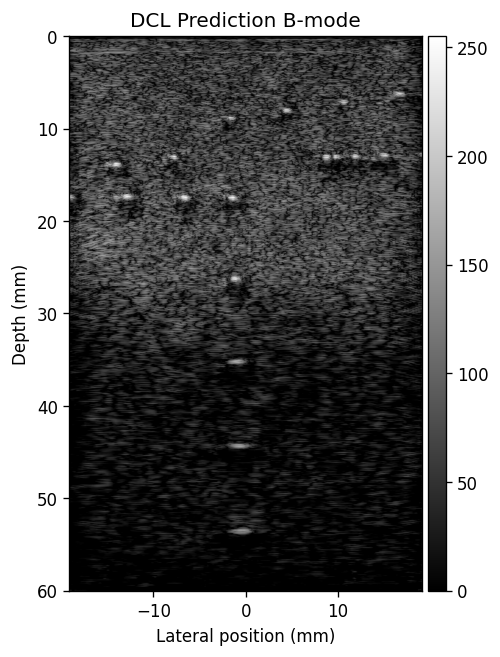

In [9]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import io, numpy as np, torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from model import DCLUNet  
from utils import init_config  


def load_iq_tensor(iq_dir: str, grid_size: int, device="cpu"):
    i_path = os.path.join(iq_dir, "bf_I_real.npy")
    q_path = os.path.join(iq_dir, "bf_Q_image.npy")

    i_data = np.load(i_path).transpose()  
    q_data = np.load(q_path).transpose()
    iq_np  = np.stack([i_data, q_data], axis=0)              
    iq     = torch.tensor(iq_np, dtype=torch.float32, device=device)

    h, w   = iq.shape[-2:]
    pad_h, pad_w = max(grid_size-h, 0), max(grid_size-w, 0)
    iq = F.pad(iq,
               (pad_w//2, pad_w-pad_w//2, pad_h//2, pad_h-pad_h//2),
               mode="constant", value=0.0)
    return iq.unsqueeze(0)                              


def load_dclunet(ckpt_path: str, device="cpu") -> DCLUNet:
    model = DCLUNet().to(device)
    with open(ckpt_path, "rb") as f:
        buffer = io.BytesIO(f.read())
    ckpt = torch.load(buffer, map_location=device)
    state = ckpt.get("model_state_dict", ckpt)
    model.load_state_dict(state, strict=False)
    model.eval()
    return model


@torch.no_grad()
def run_inference(iq: torch.Tensor, model: DCLUNet) -> torch.Tensor:
    return model(iq)


def iq_to_bmode(arr: np.ndarray, dr: int = 60) -> np.ndarray:
    if arr.ndim == 3 and arr.shape[0] == 2:    
        env = np.sqrt(arr[0]**2 + arr[1]**2)
    else:                                    
        env = np.abs(arr)
    env_safe = np.maximum(env, 1e-10)
    log_env  = 20 * np.log10(env_safe / env_safe.max())
    log_env  = np.clip(log_env, -dr, 0)
    img_255  = (log_env + dr) / dr * 255
    return img_255.astype(np.uint8)


def main() -> None:
    GRID_SIZE = 1024
    IQ_DIR = (
        fr"C:\Users\user\workspace\IqPixelGrid_HSB\IQBF_{GRID_SIZE}x{GRID_SIZE}"
    )
    CKPT_PATH = (
        r"C:\Users\user\workspace\deepcoherenceLearning_HSB\deepcoherence_code"
        r"\datasets\seongbindclcode\model_result\model_best_202532_kaiming_final.pth"
    )
    SAVE_NAME = "dclPrediction.npy"

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("🖥  device :", device)

    cfg = init_config()
    depth_mm = 60  # cfg["depth"] * 1000
    lateral_mm = cfg["View_width"] * 1000

    iq_tensor = load_iq_tensor(IQ_DIR, GRID_SIZE, device)
    print("✅ IQ tensor :", tuple(iq_tensor.shape))

    model = load_dclunet(CKPT_PATH, device)
    print("✅ Model loaded.")

    output = run_inference(iq_tensor, model)
    print("✅ Output :", tuple(output.shape))

    out_np = output.squeeze(0).cpu().numpy()
    save_path = os.path.join(IQ_DIR, SAVE_NAME)
    np.save(save_path, out_np)
    print("🖫 Saved prediction →", save_path)

    lateral_axis = np.linspace(-lateral_mm/2, lateral_mm/2, GRID_SIZE)
    depth_axis = np.linspace(0, depth_mm, GRID_SIZE)

    # (1) 입력 B-mode 출력
    input_img = iq_to_bmode(iq_tensor[0].cpu().numpy())

    fig1, ax1 = plt.subplots(figsize=(6, 6), dpi=120)
    im1 = ax1.imshow(input_img, cmap="gray", vmin=0, vmax=255, origin="upper",
                     extent=[lateral_axis[0], lateral_axis[-1], depth_axis[-1], depth_axis[0]])
    ax1.set_title("Input B-mode")
    ax1.set_xlabel("Lateral position (mm)")
    ax1.set_ylabel("Depth (mm)")

    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1)
    plt.show()

    # (2) Prediction B-mode 출력
    output_img = iq_to_bmode(out_np)

    fig2, ax2 = plt.subplots(figsize=(6, 6), dpi=120)
    im2 = ax2.imshow(output_img, cmap="gray", vmin=0, vmax=255, origin="upper",
                     extent=[lateral_axis[0], lateral_axis[-1], depth_axis[-1], depth_axis[0]])
    ax2.set_title("DCL Prediction B-mode")
    ax2.set_xlabel("Lateral position (mm)")
    ax2.set_ylabel("Depth (mm)")

    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2)
    plt.show()


if __name__ == "__main__":
    main()


🖥  device : cuda:0
Pixel Shape: 1024x1024
✅ IQ tensor : (1, 2, 1024, 1024)
✅ Model loaded.
✅ Output : (1, 2, 1024, 1024)
🖫 Saved prediction → C:\Users\user\workspace\IqPixelGrid_HSB\IQBF_50mm_1024x1024\dclPrediction.npy


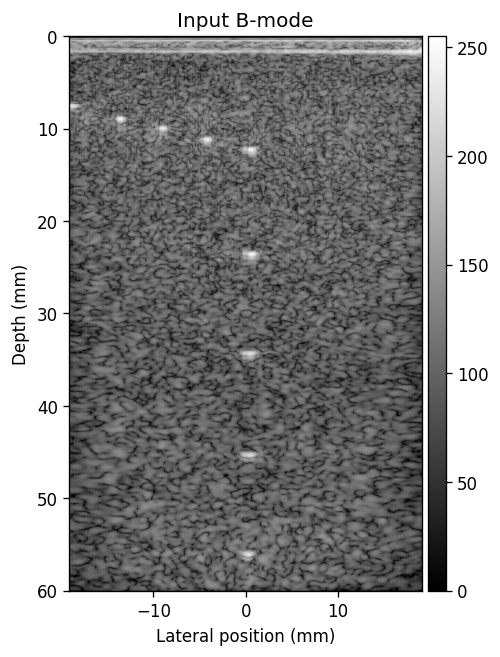

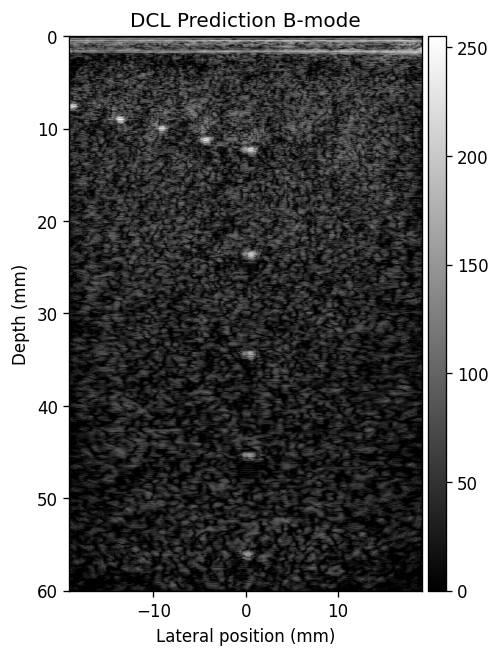

In [10]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import io, numpy as np, torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from model import DCLUNet  
from utils import init_config  


def load_iq_tensor(iq_dir: str, grid_size: int, device="cpu"):
    i_path = os.path.join(iq_dir, "bf_I_real.npy")
    q_path = os.path.join(iq_dir, "bf_Q_image.npy")

    i_data = np.load(i_path).transpose()  
    q_data = np.load(q_path).transpose()
    iq_np  = np.stack([i_data, q_data], axis=0)              
    iq     = torch.tensor(iq_np, dtype=torch.float32, device=device)

    h, w   = iq.shape[-2:]
    pad_h, pad_w = max(grid_size-h, 0), max(grid_size-w, 0)
    iq = F.pad(iq,
               (pad_w//2, pad_w-pad_w//2, pad_h//2, pad_h-pad_h//2),
               mode="constant", value=0.0)
    return iq.unsqueeze(0)                              


def load_dclunet(ckpt_path: str, device="cpu") -> DCLUNet:
    model = DCLUNet().to(device)
    with open(ckpt_path, "rb") as f:
        buffer = io.BytesIO(f.read())
    ckpt = torch.load(buffer, map_location=device)
    state = ckpt.get("model_state_dict", ckpt)
    model.load_state_dict(state, strict=False)
    model.eval()
    return model


@torch.no_grad()
def run_inference(iq: torch.Tensor, model: DCLUNet) -> torch.Tensor:
    return model(iq)


def iq_to_bmode(arr: np.ndarray, dr: int = 60) -> np.ndarray:
    if arr.ndim == 3 and arr.shape[0] == 2:    
        env = np.sqrt(arr[0]**2 + arr[1]**2)
    else:                                    
        env = np.abs(arr)
    env_safe = np.maximum(env, 1e-10)
    log_env  = 20 * np.log10(env_safe / env_safe.max())
    log_env  = np.clip(log_env, -dr, 0)
    img_255  = (log_env + dr) / dr * 255
    return img_255.astype(np.uint8)


def main() -> None:
    GRID_SIZE = 1024
    IQ_DIR = (
        fr"C:\Users\user\workspace\IqPixelGrid_HSB\IQBF_50mm_{GRID_SIZE}x{GRID_SIZE}"
    )
    CKPT_PATH = (
        r"C:\Users\user\workspace\deepcoherenceLearning_HSB\deepcoherence_code"
        r"\datasets\seongbindclcode\model_result\model_best_202532_kaiming_final.pth"
    )
    SAVE_NAME = "dclPrediction.npy"

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("🖥  device :", device)

    cfg = init_config()
    depth_mm = 60  # cfg["depth"] * 1000
    lateral_mm = cfg["View_width"] * 1000

    iq_tensor = load_iq_tensor(IQ_DIR, GRID_SIZE, device)
    print("✅ IQ tensor :", tuple(iq_tensor.shape))

    model = load_dclunet(CKPT_PATH, device)
    print("✅ Model loaded.")

    output = run_inference(iq_tensor, model)
    print("✅ Output :", tuple(output.shape))

    out_np = output.squeeze(0).cpu().numpy()
    save_path = os.path.join(IQ_DIR, SAVE_NAME)
    np.save(save_path, out_np)
    print("🖫 Saved prediction →", save_path)

    lateral_axis = np.linspace(-lateral_mm/2, lateral_mm/2, GRID_SIZE)
    depth_axis = np.linspace(0, depth_mm, GRID_SIZE)

    # (1) 입력 B-mode 출력
    input_img = iq_to_bmode(iq_tensor[0].cpu().numpy())

    fig1, ax1 = plt.subplots(figsize=(6, 6), dpi=120)
    im1 = ax1.imshow(input_img, cmap="gray", vmin=0, vmax=255, origin="upper",
                     extent=[lateral_axis[0], lateral_axis[-1], depth_axis[-1], depth_axis[0]])
    ax1.set_title("Input B-mode")
    ax1.set_xlabel("Lateral position (mm)")
    ax1.set_ylabel("Depth (mm)")

    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1)
    plt.show()

    # (2) Prediction B-mode 출력
    output_img = iq_to_bmode(out_np)

    fig2, ax2 = plt.subplots(figsize=(6, 6), dpi=120)
    im2 = ax2.imshow(output_img, cmap="gray", vmin=0, vmax=255, origin="upper",
                     extent=[lateral_axis[0], lateral_axis[-1], depth_axis[-1], depth_axis[0]])
    ax2.set_title("DCL Prediction B-mode")
    ax2.set_xlabel("Lateral position (mm)")
    ax2.set_ylabel("Depth (mm)")

    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2)
    plt.show()


if __name__ == "__main__":
    main()


🖥  device : cuda:0
Pixel Shape: 1024x1024
✅ IQ tensor : (1, 2, 1024, 1024)
✅ Model loaded.
✅ Output : (1, 2, 1024, 1024)
🖫 Saved prediction → C:\Users\user\workspace\IqPixelGrid_HSB\IQBF_50mm_1024x1024\dclPrediction.npy


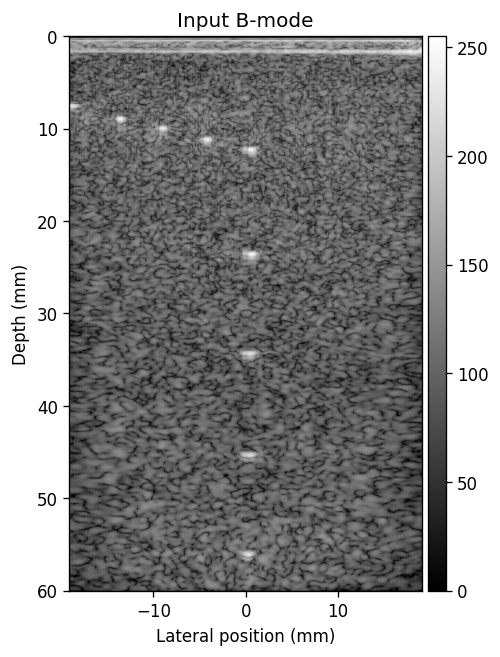

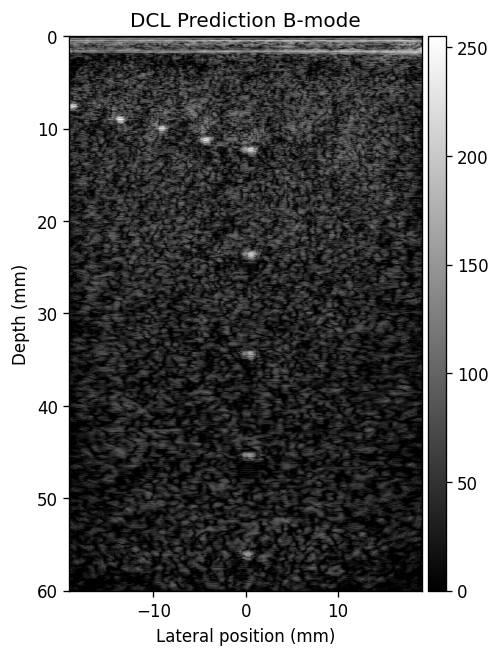

In [11]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import io, numpy as np, torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from model import DCLUNet  
from utils import init_config  


def load_iq_tensor(iq_dir: str, grid_size: int, device="cpu"):
    i_path = os.path.join(iq_dir, "bf_I_real.npy")
    q_path = os.path.join(iq_dir, "bf_Q_image.npy")

    i_data = np.load(i_path).transpose()  
    q_data = np.load(q_path).transpose()
    iq_np  = np.stack([i_data, q_data], axis=0)              
    iq     = torch.tensor(iq_np, dtype=torch.float32, device=device)

    h, w   = iq.shape[-2:]
    pad_h, pad_w = max(grid_size-h, 0), max(grid_size-w, 0)
    iq = F.pad(iq,
               (pad_w//2, pad_w-pad_w//2, pad_h//2, pad_h-pad_h//2),
               mode="constant", value=0.0)
    return iq.unsqueeze(0)                              


def load_dclunet(ckpt_path: str, device="cpu") -> DCLUNet:
    model = DCLUNet().to(device)
    with open(ckpt_path, "rb") as f:
        buffer = io.BytesIO(f.read())
    ckpt = torch.load(buffer, map_location=device)
    state = ckpt.get("model_state_dict", ckpt)
    model.load_state_dict(state, strict=False)
    model.eval()
    return model


@torch.no_grad()
def run_inference(iq: torch.Tensor, model: DCLUNet) -> torch.Tensor:
    return model(iq)


def iq_to_bmode(arr: np.ndarray, dr: int = 60) -> np.ndarray:
    if arr.ndim == 3 and arr.shape[0] == 2:    
        env = np.sqrt(arr[0]**2 + arr[1]**2)
    else:                                    
        env = np.abs(arr)
    env_safe = np.maximum(env, 1e-10)
    log_env  = 20 * np.log10(env_safe / env_safe.max())
    log_env  = np.clip(log_env, -dr, 0)
    img_255  = (log_env + dr) / dr * 255
    return img_255.astype(np.uint8)


def main() -> None:
    GRID_SIZE = 1024
    IQ_DIR = (
        fr"C:\Users\user\workspace\IqPixelGrid_HSB\IQBF_50mm_{GRID_SIZE}x{GRID_SIZE}"
    )
    CKPT_PATH = (
        r"C:\Users\user\workspace\deepcoherenceLearning_HSB\deepcoherence_code"
        r"\datasets\seongbindclcode\model_result\model_best_202532_kaiming_final.pth"
    )
    SAVE_NAME = "dclPrediction.npy"

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("🖥  device :", device)

    cfg = init_config()
    depth_mm = 60  # cfg["depth"] * 1000
    lateral_mm = cfg["View_width"] * 1000

    iq_tensor = load_iq_tensor(IQ_DIR, GRID_SIZE, device)
    print("✅ IQ tensor :", tuple(iq_tensor.shape))

    model = load_dclunet(CKPT_PATH, device)
    print("✅ Model loaded.")

    output = run_inference(iq_tensor, model)
    print("✅ Output :", tuple(output.shape))

    out_np = output.squeeze(0).cpu().numpy()
    save_path = os.path.join(IQ_DIR, SAVE_NAME)
    np.save(save_path, out_np)
    print("🖫 Saved prediction →", save_path)

    lateral_axis = np.linspace(-lateral_mm/2, lateral_mm/2, GRID_SIZE)
    depth_axis = np.linspace(0, depth_mm, GRID_SIZE)

    # (1) 입력 B-mode 출력
    input_img = iq_to_bmode(iq_tensor[0].cpu().numpy())

    fig1, ax1 = plt.subplots(figsize=(6, 6), dpi=120)
    im1 = ax1.imshow(input_img, cmap="gray", vmin=0, vmax=255, origin="upper",
                     extent=[lateral_axis[0], lateral_axis[-1], depth_axis[-1], depth_axis[0]])
    ax1.set_title("Input B-mode")
    ax1.set_xlabel("Lateral position (mm)")
    ax1.set_ylabel("Depth (mm)")

    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1)
    plt.show()

    # (2) Prediction B-mode 출력
    output_img = iq_to_bmode(out_np)

    fig2, ax2 = plt.subplots(figsize=(6, 6), dpi=120)
    im2 = ax2.imshow(output_img, cmap="gray", vmin=0, vmax=255, origin="upper",
                     extent=[lateral_axis[0], lateral_axis[-1], depth_axis[-1], depth_axis[0]])
    ax2.set_title("DCL Prediction B-mode")
    ax2.set_xlabel("Lateral position (mm)")
    ax2.set_ylabel("Depth (mm)")

    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2)
    plt.show()


if __name__ == "__main__":
    main()


🖥  device : cuda:0
Pixel Shape: 1024x1024
✅ IQ tensor : (1, 2, 1024, 1024)
✅ Model loaded.
✅ Output : (1, 2, 1024, 1024)
🖫 Saved prediction → C:\Users\user\workspace\IqPixelGrid_HSB\IQBF_RF_data_1_1024x1024\dclPrediction.npy


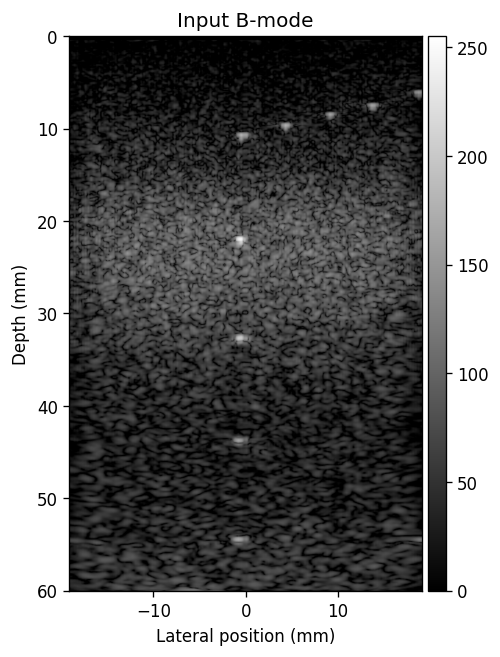

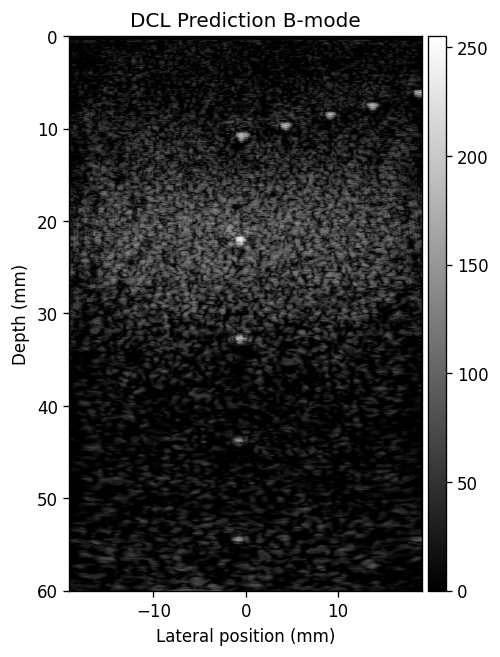

In [12]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import io, numpy as np, torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from model import DCLUNet  
from utils import init_config  


def load_iq_tensor(iq_dir: str, grid_size: int, device="cpu"):
    i_path = os.path.join(iq_dir, "bf_I_real.npy")
    q_path = os.path.join(iq_dir, "bf_Q_image.npy")

    i_data = np.load(i_path).transpose()  
    q_data = np.load(q_path).transpose()
    iq_np  = np.stack([i_data, q_data], axis=0)              
    iq     = torch.tensor(iq_np, dtype=torch.float32, device=device)

    h, w   = iq.shape[-2:]
    pad_h, pad_w = max(grid_size-h, 0), max(grid_size-w, 0)
    iq = F.pad(iq,
               (pad_w//2, pad_w-pad_w//2, pad_h//2, pad_h-pad_h//2),
               mode="constant", value=0.0)
    return iq.unsqueeze(0)                              


def load_dclunet(ckpt_path: str, device="cpu") -> DCLUNet:
    model = DCLUNet().to(device)
    with open(ckpt_path, "rb") as f:
        buffer = io.BytesIO(f.read())
    ckpt = torch.load(buffer, map_location=device)
    state = ckpt.get("model_state_dict", ckpt)
    model.load_state_dict(state, strict=False)
    model.eval()
    return model


@torch.no_grad()
def run_inference(iq: torch.Tensor, model: DCLUNet) -> torch.Tensor:
    return model(iq)


def iq_to_bmode(arr: np.ndarray, dr: int = 60) -> np.ndarray:
    if arr.ndim == 3 and arr.shape[0] == 2:    
        env = np.sqrt(arr[0]**2 + arr[1]**2)
    else:                                    
        env = np.abs(arr)
    env_safe = np.maximum(env, 1e-10)
    log_env  = 20 * np.log10(env_safe / env_safe.max())
    log_env  = np.clip(log_env, -dr, 0)
    img_255  = (log_env + dr) / dr * 255
    return img_255.astype(np.uint8)


def main() -> None:
    GRID_SIZE = 1024
    IQ_DIR = (
        fr"C:\Users\user\workspace\IqPixelGrid_HSB\IQBF_RF_data_1_{GRID_SIZE}x{GRID_SIZE}"
    )
    CKPT_PATH = (
        r"C:\Users\user\workspace\deepcoherenceLearning_HSB\deepcoherence_code"
        r"\datasets\seongbindclcode\model_result\model_best_202532_kaiming_final.pth"
    )
    SAVE_NAME = "dclPrediction.npy"

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("🖥  device :", device)

    cfg = init_config()
    depth_mm = 60  # cfg["depth"] * 1000
    lateral_mm = cfg["View_width"] * 1000

    iq_tensor = load_iq_tensor(IQ_DIR, GRID_SIZE, device)
    print("✅ IQ tensor :", tuple(iq_tensor.shape))

    model = load_dclunet(CKPT_PATH, device)
    print("✅ Model loaded.")

    output = run_inference(iq_tensor, model)
    print("✅ Output :", tuple(output.shape))

    out_np = output.squeeze(0).cpu().numpy()
    save_path = os.path.join(IQ_DIR, SAVE_NAME)
    np.save(save_path, out_np)
    print("🖫 Saved prediction →", save_path)

    lateral_axis = np.linspace(-lateral_mm/2, lateral_mm/2, GRID_SIZE)
    depth_axis = np.linspace(0, depth_mm, GRID_SIZE)

    # (1) 입력 B-mode 출력
    input_img = iq_to_bmode(iq_tensor[0].cpu().numpy())

    fig1, ax1 = plt.subplots(figsize=(6, 6), dpi=120)
    im1 = ax1.imshow(input_img, cmap="gray", vmin=0, vmax=255, origin="upper",
                     extent=[lateral_axis[0], lateral_axis[-1], depth_axis[-1], depth_axis[0]])
    ax1.set_title("Input B-mode")
    ax1.set_xlabel("Lateral position (mm)")
    ax1.set_ylabel("Depth (mm)")

    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1)
    plt.show()

    # (2) Prediction B-mode 출력
    output_img = iq_to_bmode(out_np)

    fig2, ax2 = plt.subplots(figsize=(6, 6), dpi=120)
    im2 = ax2.imshow(output_img, cmap="gray", vmin=0, vmax=255, origin="upper",
                     extent=[lateral_axis[0], lateral_axis[-1], depth_axis[-1], depth_axis[0]])
    ax2.set_title("DCL Prediction B-mode")
    ax2.set_xlabel("Lateral position (mm)")
    ax2.set_ylabel("Depth (mm)")

    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2)
    plt.show()


if __name__ == "__main__":
    main()


🖥  device : cuda:0
Pixel Shape: 1024x1024
===== IQ Tensor Raw Stats =====
I: min=-2.343e-01, max=1.494e-01, mean=9.659e-07, std=2.039e-03
Q: min=-1.960e-01, max=1.423e-01, mean=-4.053e-06, std=1.950e-03
Envelope: min=0.000e+00, max=2.646e-01, mean=1.635e-04, std=2.816e-03
Applying static gain factor: 10.000
✅ IQ tensor : (1, 2, 512, 512)
✅ Model loaded.
✅ Output : (1, 2, 512, 512)
🖫 Saved prediction → C:\Users\user\workspace\IqPixelGrid_HSB\IQBF_RcvData_512x512\dclPrediction_static.npy


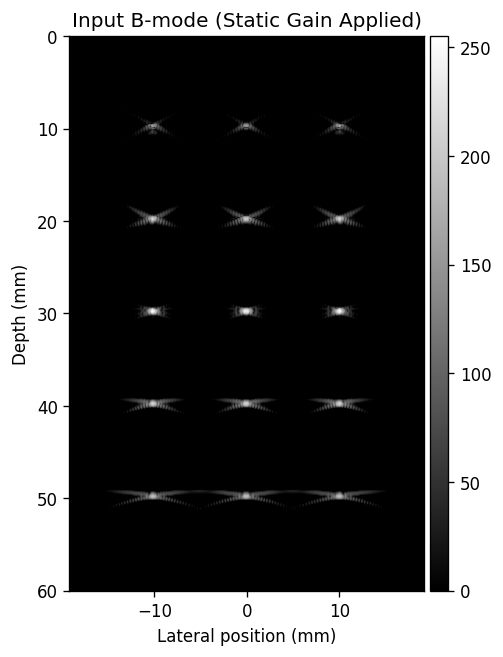

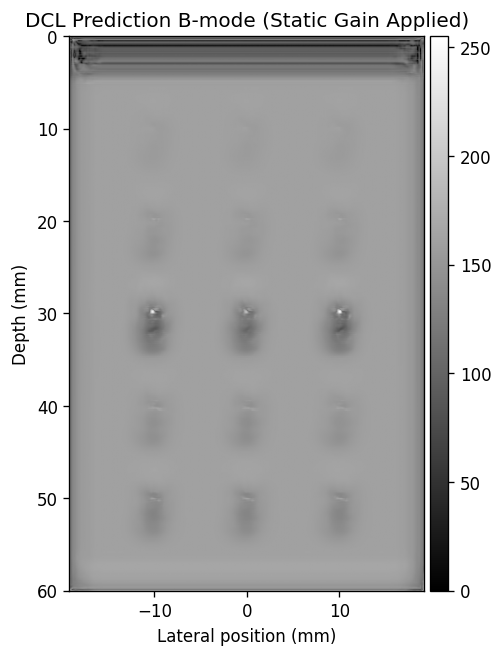

In [13]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import io, numpy as np, torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from model import DCLUNet  
from utils import init_config_3, load_mat_data_3, rectwin


def load_iq_tensor(iq_dir: str, grid_size: int, device="cpu", static_gain=10.0):
    i_path = os.path.join(iq_dir, "bf_I_real.npy")
    q_path = os.path.join(iq_dir, "bf_Q_image.npy")

    i_data = np.load(i_path).transpose()  
    q_data = np.load(q_path).transpose()
    iq_np  = np.stack([i_data, q_data], axis=0)

    # 디버깅: raw amplitude 스케일 출력
    print("===== IQ Tensor Raw Stats =====")
    print(f"I: min={i_data.min():.3e}, max={i_data.max():.3e}, mean={i_data.mean():.3e}, std={i_data.std():.3e}")
    print(f"Q: min={q_data.min():.3e}, max={q_data.max():.3e}, mean={q_data.mean():.3e}, std={q_data.std():.3e}")
    env = np.sqrt(i_data**2 + q_data**2)
    print(f"Envelope: min={env.min():.3e}, max={env.max():.3e}, mean={env.mean():.3e}, std={env.std():.3e}")
    print("="*40)

    # ✅ Static gain compensation
    print(f"Applying static gain factor: {static_gain:.3f}")
    iq_np_scaled = iq_np * static_gain

    iq = torch.tensor(iq_np_scaled, dtype=torch.float32, device=device)

    h, w = iq.shape[-2:]
    pad_h, pad_w = max(grid_size-h, 0), max(grid_size-w, 0)
    iq = F.pad(iq,
               (pad_w//2, pad_w-pad_w//2, pad_h//2, pad_h-pad_h//2),
               mode="constant", value=0.0)
    return iq.unsqueeze(0), iq_np_scaled


def load_dclunet(ckpt_path: str, device="cpu") -> DCLUNet:
    model = DCLUNet().to(device)
    with open(ckpt_path, "rb") as f:
        buffer = io.BytesIO(f.read())
    ckpt = torch.load(buffer, map_location=device)
    state = ckpt.get("model_state_dict", ckpt)
    model.load_state_dict(state, strict=False)
    model.eval()
    return model


@torch.no_grad()
def run_inference(iq: torch.Tensor, model: DCLUNet) -> torch.Tensor:
    return model(iq)


def iq_to_bmode(arr: np.ndarray, dr: int = 60) -> np.ndarray:
    if arr.ndim == 3 and arr.shape[0] == 2:    
        env = np.sqrt(arr[0]**2 + arr[1]**2)
    else:                                    
        env = np.abs(arr)
    env_safe = np.maximum(env, 1e-10)
    log_env  = 20 * np.log10(env_safe / env_safe.max())
    log_env  = np.clip(log_env, -dr, 0)
    img_255  = (log_env + dr) / dr * 255
    return img_255.astype(np.uint8)


def main() -> None:
    GRID_SIZE = 512
    IQ_DIR = (
        fr"C:\Users\user\workspace\IqPixelGrid_HSB\IQBF_RcvData_{GRID_SIZE}x{GRID_SIZE}"
    )
    CKPT_PATH = (
        r"C:\Users\user\workspace\deepcoherenceLearning_HSB\deepcoherence_code"
        r"\datasets\seongbindclcode\model_result\model_best_202532_kaiming_final.pth"
    )
    SAVE_NAME = "dclPrediction_static.npy"

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("🖥  device :", device)

    cfg = init_config_3()
    depth_mm = 60  
    lateral_mm = cfg["View_width"] * 1000

    static_gain = 10.0  # ✅ 여기서 gain 값만 쉽게 조절 가능!
    iq_tensor, iq_np_scaled = load_iq_tensor(IQ_DIR, GRID_SIZE, device, static_gain)
    print("✅ IQ tensor :", tuple(iq_tensor.shape))

    model = load_dclunet(CKPT_PATH, device)
    print("✅ Model loaded.")

    output = run_inference(iq_tensor, model)
    print("✅ Output :", tuple(output.shape))

    out_np = output.squeeze(0).cpu().numpy()

    save_path = os.path.join(IQ_DIR, SAVE_NAME)
    np.save(save_path, out_np)
    print("🖫 Saved prediction →", save_path)

    lateral_axis = np.linspace(-lateral_mm/2, lateral_mm/2, GRID_SIZE)
    depth_axis = np.linspace(0, depth_mm, GRID_SIZE)

    ### (1) 입력 B-mode 출력 (scaled IQ)
    input_img = iq_to_bmode(iq_np_scaled)

    fig1, ax1 = plt.subplots(figsize=(6, 6), dpi=120)
    im1 = ax1.imshow(input_img, cmap="gray", vmin=0, vmax=255, origin="upper",
                     extent=[lateral_axis[0], lateral_axis[-1], depth_axis[-1], depth_axis[0]])
    ax1.set_title("Input B-mode (Static Gain Applied)")
    ax1.set_xlabel("Lateral position (mm)")
    ax1.set_ylabel("Depth (mm)")
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1)
    plt.show()

    ### (2) Prediction B-mode 출력
    output_img = iq_to_bmode(out_np)

    fig2, ax2 = plt.subplots(figsize=(6, 6), dpi=120)
    im2 = ax2.imshow(output_img, cmap="gray", vmin=0, vmax=255, origin="upper",
                     extent=[lateral_axis[0], lateral_axis[-1], depth_axis[-1], depth_axis[0]])
    ax2.set_title("DCL Prediction B-mode (Static Gain Applied)")
    ax2.set_xlabel("Lateral position (mm)")
    ax2.set_ylabel("Depth (mm)")
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2)
    plt.show()


if __name__ == "__main__":
    main()


In [14]:
# import numpy as np
# import torch
# import matplotlib.pyplot as plt
# from scipy.interpolate import griddata
# from pathlib import Path

# # ───────────────────────────── Probe · 시스템 파라미터 (Convex)
# C, Fs = 1540.0, 40e6
# Unit_Dis = C / (2 * Fs)
# N_scanline = 128
# view_angle_rad = np.deg2rad(58.1154)
# Array_radius = 60e-3
# depth_max_m = 100e-3

# # ───────────────────────────── IQ bin 로드
# bin_path = Path(
#     r"C:\Users\user\workspace\IqPixelGrid_HSB\beamformed_data\sum_out_IQ.bin"
# )
# iq_flat = np.fromfile(bin_path, dtype=np.complex64)
# depth_len = iq_flat.size // N_scanline
# iq = iq_flat.reshape(depth_len, N_scanline)  # (depth, scanline)

# # ───────────────────────────── Envelope(dB)
# env = np.abs(iq)
# env /= env.max() + 1e-12
# env_db = 20 * np.log10(env + 1e-8)

# # ───────────────────────────── Polar → (x,z) 좌표
# δθ = view_angle_rad / (N_scanline - 1)
# angles = -view_angle_rad / 2 + np.arange(N_scanline) * δθ
# depth_arr = np.arange(depth_len) * Unit_Dis

# θg, dg = np.meshgrid(angles, depth_arr, indexing="ij")
# r_total = Array_radius + dg
# x_scat = r_total * np.sin(θg)
# z_scat = r_total * np.cos(θg) - Array_radius

# pts = np.column_stack((x_scat.ravel(), z_scat.ravel()))
# vals = env_db.T.ravel()

# # ───────────────────────────── 출력 디렉터리
# save_dir = Path(
#     r"C:\Users\user\workspace\IqPixelGrid_HSB\beamformed_data"
# )
# save_dir.mkdir(parents=True, exist_ok=True)

# # ───────────────────────────── Cartesian 변환
# x_ext = (Array_radius + depth_max_m) * np.sin(view_angle_rad / 2)
# xlim, zlim = (-x_ext, x_ext), (0.0, depth_max_m)

# # 해상도 목록 (64 포함)
# for res in [64, 256, 512, 1024, 2048]:
#     # 1) 균일 x–z 그리드
#     xs = np.linspace(*xlim, res)
#     zs = np.linspace(*zlim, res)
#     grid_x, grid_z = np.meshgrid(xs, zs)

#     # 2) 보간 → dB 이미지
#     img_db = griddata(pts, vals, (grid_x, grid_z), method="linear", fill_value=-120)

#     # 3) dB → 선형(0-1) & 두 채널 스택
#     img_lin = 10 ** (img_db / 20)
#     tensor = torch.from_numpy(np.stack([img_lin, img_lin])).float().unsqueeze(0)

#     # 4) 저장
#     pt_path = save_dir / f"convex_env_{res}.pt"
#     torch.save(tensor, pt_path)
#     print(f"Saved tensor {tuple(tensor.shape)} → {pt_path}")

#     # 5) 미리보기 (컬러바 포함)
#     plt.figure(figsize=(4, 4))
#     im = plt.imshow(
#         img_db,
#         cmap="gray",
#         extent=[*xlim, *zlim[::-1]],
#         vmin=-60,
#         vmax=0,
#         aspect="equal",
#     )
#     plt.title(f"B-mode {res}×{res}")
#     plt.axis("off")
#     cbar = plt.colorbar(im, fraction=0.046, pad=0.04, shrink=0.5)
#     cbar.set_label("Amplitude (dB)")
#     plt.tight_layout()
#     plt.show()